In [1]:
pip install keras

# **Importing Necessary Dependencies**

In [2]:
import numpy as np
from math import sqrt
from pandas import read_csv
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import make_interp_spline

from keras.callbacks import CSVLogger
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import Dropout

from statsmodels.tsa.seasonal import seasonal_decompose

# **Helper Functions Defined**

In [3]:
from keras.backend import dropout
# split  dataset into train, validate and test sets
def split_dataset(data):
	# split into train validation and test sets
	train, val, test = data[12:13932], data [13932:18300], data[18300:22716]
	# restructure into samples of daily data shape is [samples, hours, feature]
	train = np.array(np.split(train, len(train)/24))
	val = np.array(np.split(val, len(val)/24))
	test = np.array(np.split(test, len(test)/24))
	return train, val, test

# evaluate one or more daily forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each hour of the day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store in scores list
		scores.append(rmse)

	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs (actual) and outputs (predicted) for training
def convert_train_val(train, n_input, n_out=24):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step of 1 hour
		in_start += 1
	return np.array(X), np.array(y)

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1] that is 1 sample, sample data size, one feature
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next hour
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# **LSTM - Building Model Architecture and Training**

In [4]:
# train the model
def build_model_LSTM(train, val, n_input):
	# Create training and validation sets
	train_x, train_y = convert_train_val(train, n_input)
	val_x, val_y = convert_train_val(val, n_input)
	# define parameters
	csv_logger = CSVLogger('LSTM_Model_Logger.log')
	verbose, epochs, batch_size = 1, 3, 384
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	nv_timesteps, nv_features, nv_outputs = val_x.shape[1], val_x.shape[2], val_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	val_y = val_y.reshape((val_y.shape[0], val.shape[1], 1))

	# define model
	model = Sequential()
	model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_timesteps, 1)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	print(model.summary())
	# fit network
	hist=model.fit(train_x, train_y, validation_data=(val_x, val_y),callbacks=[csv_logger], epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model, hist

# evaluate model fits model using training and validation data, then conducts a walk forwad validation with the test data
def evaluate_model_LSTM(train, val, test, n_input):
	# fit model
	model, hist = build_model_LSTM(train, val, n_input)
	# history is a list of houry data
	history = [x for x in train]
	# walk-forward validation over each hour in test set
	predictions = list()
	for i in range(len(test)):
		# predict the hour
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next hour
		history.append(test[i, :])
	# evaluate predictions hours for each day
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores, hist, predictions

# **CNN - Building Model Architecture and Training**

In [5]:
# Build and train CNN-BiLSTM model
def build_model_CNNLSTM(train, val, n_input):
	# Create training and validation sets
	train_x, train_y = convert_train_val(train, n_input)
	val_x, val_y = convert_train_val(val, n_input)
	# define parameters
	csv_logger = CSVLogger('CNNLSTM_Model_Logger.log')
	verbose, epochs, batch_size = 1, 3, 384
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	nv_timesteps, nv_features, nv_outputs = val_x.shape[1], val_x.shape[2], val_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	val_y = val_y.reshape((val_y.shape[0], val.shape[1], 1))
	# define model

	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(100, return_sequences=True, activation='relu', input_shape=(n_timesteps, 1)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	print(model.summary())
	# fit network and store mse loss in hist
	hist=model.fit(train_x, train_y, validation_data=(val_x, val_y),callbacks=[csv_logger], epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model, hist

# evaluate model fits model using training and validation data, then conducts a walk forwad validation with the test data
def evaluate_model_CNNLSTM(train, val, test, n_input):
	# fit model
	model, hist = build_model_CNNLSTM(train, val, n_input)
	# history is a list of houry data
	history = [x for x in train]
	# walk-forward validation over each hour in test set
	predictions = list()
	for i in range(len(test)):
		# predict the hour
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next hour
		history.append(test[i, :])
	# evaluate predictions hours for each day
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores, hist, predictions

# **BiLSTM - Building Model Architecture and Training**

In [6]:
# Build and train BiLSTM model
def build_model_BiLSTM(train, val, n_input):
	# Create training and validation sets
	train_x, train_y = convert_train_val(train, n_input)
	val_x, val_y = convert_train_val(val, n_input)
	# define parameters
	csv_logger = CSVLogger('BiLSTM_Model_Logger.log')
	verbose, epochs, batch_size = 1, 3, 384
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	nv_timesteps, nv_features, nv_outputs = val_x.shape[1], val_x.shape[2], val_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	val_y = val_y.reshape((val_y.shape[0], val.shape[1], 1))
	# define model
	model = Sequential()
	model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True), input_shape=(n_timesteps, 1)))
	# model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True)))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	print(model.summary())
	# fit network and store mse loss in hist
	hist=model.fit(train_x, train_y, validation_data=(val_x, val_y),callbacks=[csv_logger], epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model, hist

# evaluate model fits model using training and validation data, then conducts a walk forwad validation with the test data
def evaluate_model_BiLSTM(train, val, test, n_input):
	# fit model
	model, hist = build_model_BiLSTM(train, val, n_input)
	# history is a list of houry data
	history = [x for x in train]
	# walk-forward validation over each hour in test set
	predictions = list()
	for i in range(len(test)):
		# predict the hour
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next hour
		history.append(test[i, :])
	# evaluate predictions hours for each day
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores, hist, predictions

# **Load Dataset**

In [7]:
dataset = read_csv('/content/data_spatial_TotalKW.csv', header=0,
                   infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

<ipython-input-7-ed1025b11690>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv('/content/data_spatial_TotalKW.csv', header=0,


# **Data Decomposition into - Trend, Seasonality, and Noise**

<Figure size 640x480 with 0 Axes>

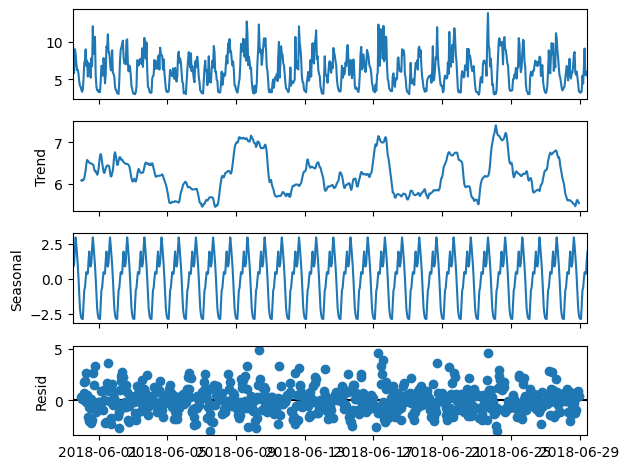

In [8]:
# Display and decompose data into trend, seasonality, noise
fig1 = plt.gcf()
month = dataset.iloc[0:720]
decomp = seasonal_decompose(month, model='additive')
decomp.plot()
plt.show()
fig1.savefig('seasonal_decompose.pdf')

# **Normalization - Normalize data using min-max scaling**

In [9]:
trans = MinMaxScaler()
dataset = trans.fit_transform(dataset)
tran_scale = trans.scale_

# split into train and test
train, val, test = split_dataset(dataset)
print('train size: ', train.shape)
print('valid size: ', val.shape)
print('test size : ', test.shape)
print('tran size : ', tran_scale)

train size:  (580, 24, 1)
valid size:  (182, 24, 1)
test size :  (184, 24, 1)
tran size :  [0.05137161]


# **Naive Forecasting Technique**

In [10]:
# Perform naive prediction
N_actual= test[1:184]/tran_scale
N_predicted = test[0:183]/tran_scale

N_score, N_scores = evaluate_forecasts(N_actual, N_predicted)

print('N_actual size: ', N_actual.shape)
print('Avg. score: ', N_score)

# summarize rmse scores
summarize_scores('rmse', N_score, N_scores)

N_actual size:  (183, 24, 1)
Avg. score:  1.786631258343538
rmse: [1.787] 0.5, 0.5, 0.5, 0.7, 1.1, 1.5, 1.4, 2.0, 2.5, 2.6, 3.1, 2.4, 2.4, 2.1, 2.1, 2.3, 2.4, 2.0, 1.6, 1.5, 1.1, 0.8, 0.7, 0.6


<ipython-input-3-267ce7a92e08>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = sqrt(s / (actual.shape[0] * actual.shape[1]))


# **LSTM Model Evaluation**

In [11]:
# evaluate model and get scores
n_input = 24
LSTM_score, LSTM_scores, hist, predictions_LSTM = evaluate_model_LSTM(train, val, test, n_input)
LSTM_score, LSTM_scores, predictions_LSTM = LSTM_score/tran_scale , LSTM_scores/tran_scale, predictions_LSTM/tran_scale

print('Avg. LSTM score: ', LSTM_score)

# summarize rmse scores
summarize_scores('rmse', LSTM_score, LSTM_scores)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 100)           40800     
                                                                 
 dense (Dense)               (None, 24, 100)           10100     
                                                                 
 dense_1 (Dense)             (None, 24, 1)             101       
                                                                 
Total params: 51001 (199.22 KB)
Trainable params: 51001 (199.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/3
37/37 [==============================] - 7s 133ms/step - loss: 0.0362 - val_loss: 0.0132
Epoch 2/3
37/37 [==============================] - 9s 242ms/step - loss: 0.0124 - val_loss: 0.0085
Epoch 3/3
37/37 [==============================] - 9s 253ms/step - loss: 0.0098

<ipython-input-3-267ce7a92e08>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = sqrt(s / (actual.shape[0] * actual.shape[1]))
<ipython-input-3-267ce7a92e08>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%s: [%.3f] %s' % (name, score, s_scores))


In [12]:
# evaluate model and get scores
n_input = 24
CNNL_score, CNNL_scores, hist_CNNL, predictions_CNNL = evaluate_model_CNNLSTM(train, val, test, n_input)
CNNL_score, CNNL_scores, predictions_CNNL = CNNL_score/tran_scale , CNNL_scores/tran_scale, predictions_CNNL/tran_scale

print('Avg. CNN score: ', CNNL_score)

# summarize rmse scores
summarize_scores('rmse', CNNL_score, CNNL_scores)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 64)            256       
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 64)            12352     
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 24, 640)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 24, 100)          

<ipython-input-3-267ce7a92e08>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = sqrt(s / (actual.shape[0] * actual.shape[1]))
<ipython-input-3-267ce7a92e08>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%s: [%.3f] %s' % (name, score, s_scores))


# **BiLSTM Model Evaluation**

In [13]:
# evaluate model and get scores
n_input = 24
BL_score, BL_scores, hist, predictions_BL = evaluate_model_BiLSTM(train, val, test, n_input)
BL_score, BL_scores, predictions_BL = BL_score/tran_scale , BL_scores/tran_scale, predictions_BL/tran_scale

print('Avg. score: ', BL_score)

# summarize rmse scores
summarize_scores('rmse', BL_score, BL_scores)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 24, 200)           81600     
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 24, 100)           20100     
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 24, 1)             101       
 stributed)                                                      
                                                                 
Total params: 101801 (397.66 KB)
Trainable params: 101801 (397.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/3
37/37 [==============================] - 11s 223ms/step - loss: 0

<ipython-input-3-267ce7a92e08>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = sqrt(s / (actual.shape[0] * actual.shape[1]))
<ipython-input-3-267ce7a92e08>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%s: [%.3f] %s' % (name, score, s_scores))


# **Comparative Study - Plot an example prediction of each model**

In [14]:
hours = ['1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', '12','13', '14', '15', '16', '17', '18', '19','20', '21', '22', '23', '24' ]


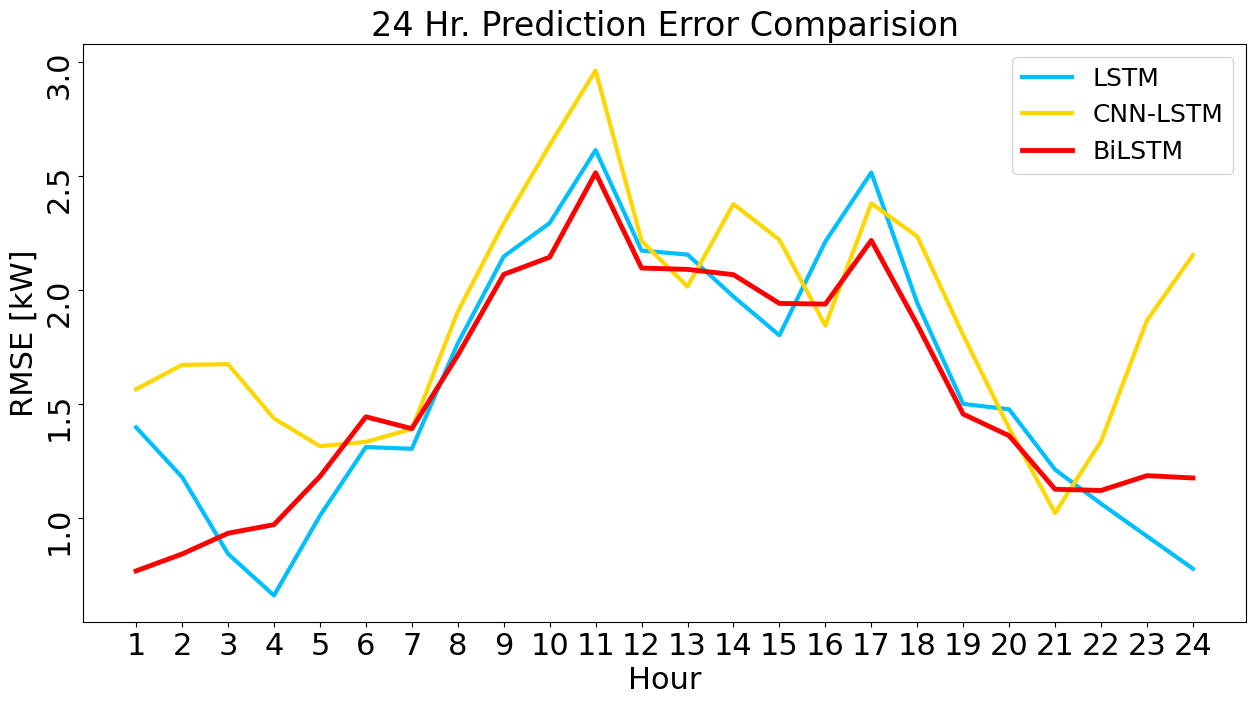

In [16]:
# fig2 = plt.gcf()
plt.figure(figsize=(15, 7.5))
# plt.plot(hours, N_scores, 'blue', label='XgBoost', linewidth=3)
plt.plot(hours, LSTM_scores, 'deepskyblue', label='LSTM', linewidth=3)
plt.plot(hours, CNNL_scores, 'gold', label='CNN-LSTM', linewidth=3)
# plt.plot(hours, CNNBL_scores, 'forestgreen', label='CNN', linewidth=3)
plt.plot(hours, BL_scores, 'r', label='BiLSTM', linewidth=3.5)
plt.title('24 Hr. Prediction Error Comparision', fontsize=24)
plt.xlabel("Hour", fontsize=22)
plt.ylabel("RMSE [kW]", fontsize=22)
plt.legend(loc='upper right', fontsize=18)
plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=90)

plt.savefig('RMSE-comparision.pdf')

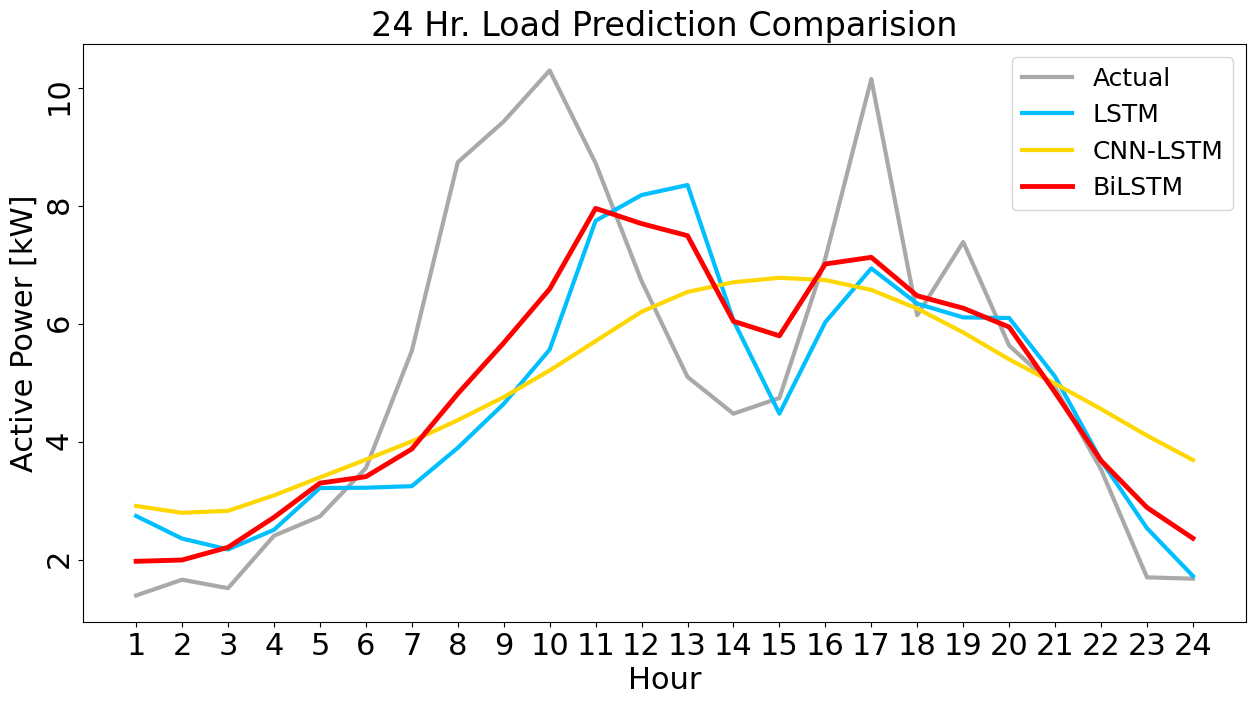

In [17]:
# fig3 = plt.gcf()
plt.figure(figsize=(15, 7.5))
plt.plot(hours, N_actual[15], 'darkgrey', label='Actual', linewidth=3)
# plt.plot(hours, N_predicted[15], 'b', label='XgBoost', linewidth=3)
plt.plot(hours, predictions_LSTM[15], 'deepskyblue', label='LSTM', linewidth=3)
plt.plot(hours, predictions_CNNL[15], 'gold', label='CNN-LSTM', linewidth=3)
# plt.plot(hours, predictions_CNNBL[15], 'forestgreen', label='CNN', linewidth=3)
plt.plot(hours, predictions_BL[15], 'r', label='BiLSTM', linewidth=3.5)
plt.title('24 Hr. Load Prediction Comparision', fontsize=24)
plt.xlabel("Hour", fontsize=22)
plt.ylabel("Active Power [kW]", fontsize=22)
plt.legend(loc='upper right', fontsize=18)
plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=90)

plt.savefig('model-predictions-comparision.pdf')